# XSuite language and Octupoles studies
## XSuite baby steps

Xsuite is a collection Python packages for the simulation of the beam dynamics in LHC. In this package we can simulate multi-particle behaviours and thanks to Python have an immediate interface to the problem.
Let's have a look at the imports:
- xobject is used to decide whether to program on CPU or GPU;
- xtrack is used to load the lattice and to track the particles
- xpart is used to define the particles to be tracked

In [3]:
import numpy as np
import xobjects as xo
import xtrack as xt
import xpart as xp
import json
import pandas as pd
from cpymad.madx import Madx
from matplotlib import pyplot as plt
%matplotlib inline
import NAFFlib

We will work on the CPU.

In [4]:
ctx = xo.ContextCpu()

## Coding steps
Unfortunately together with Guido we found out that there is a bug that negates the possibility to use (for the moment) the HL-LHC lattice for the study. We will use the run 3 lattice.
The problem, once understood, can be divided into these steps:
- Create a lattice that is readable by XSuite environment;
- In this lattice you need to be able to activate the "knobs" and to control them. This is the strength of the new environment created at CERN: the "knobs" are the main variables of the simulation, and are sort of control buttons of the LHC; when programming in pure MADx you need to modify these "knobs" manually into the code and rerun the simulation, whereas by interfacing the code with Python it is possible to modify the "knobs" on the run.
- Find the closed orbit into the created lattice and simulate the particles.

First of all we need to **load the lattice**. This can be done in various way, starting from a MADx file or a json file. In this case i produced a json file from the Run 3 simulation with the knobs activated.

In [5]:
mad = Madx()
mad.call('/afs/cern.ch/user/a/afornara/simulations/2022_02_07/temp/lhcmask/python_examples/run3_collisions_python/andrea.madx')
mad.use(sequence="lhcb1")

In [6]:
#mad.globals.i_mo

In [7]:
#mad.globals.on_bb_charge
#mad.twiss().dframe()

In [8]:
if False:
    with open('/afs/cern.ch/user/a/afornara/simulations/2022_02_07/temp/lhcmask/python_examples/run3_collisions_python/andrea.madx', 'r') as the_lhc:
     loaded_lhc = json.load(the_lhc)
    line = xt.Line.from_dict(loaded_lhc)

The Line object, here called line for simplicity is the **LHC lattice**, as seen by beam 1.

In [9]:
#line.element_names
line = xt.Line.from_madx_sequence(mad.sequence['lhcb1'],
                                  deferred_expressions=True
                                  )

The knob containing the Octupole current is named 'i_mo', we can now see what value was decided for it by default by printing it out (notice that we are now always referring to the line, farewell MAD-X.)

In [10]:
print(line.vars['i_mo']._get_value())

-350.0


In [11]:

#Qui ho definito v, lettera a caso, per accedere con dir e con v. alla roba li dentro
#v=line.element_dict['mqwa.a4r3.b1..2']
#dir(v)
#v.order

#Scorrere sugli ottupoli
sum_nl = 0.0
count_nl = 0
sum_sl = 0.0
count_sl = 0
for elem in line.element_dict :
    if isinstance(line.element_dict[elem],xt.beam_elements.elements.Multipole):   
        if(line.element_dict[elem].order==3):
                #i print sono giusti, li commento perché sono lunghi
                sum_nl+=line.element_dict[elem].knl[3]
                count_nl+=1
                sum_sl+=line.element_dict[elem].ksl
                count_sl+=1
                #print(elem)
                #print(line.element_dict[elem].knl)
K_OCT = sum_nl/count_nl
K_OCT

-0.6894449027659545

In [10]:
#Come sopra, sono lunghi ma e giusto
#line.element_dict


For example with the command ```line.element_names``` we can see all the elements present in the lattice, and in particular we discover that this lattice starts at ip3.
Now we want to define a particle. There are various ways to define particles, for example these 2.

In [12]:
line.particle_ref = xp.Particles(_context=ctx,
                        p0c=7000e9,
                        x=[1.00951707e-08],px=[1.69518015e-10],
                        y=[4.51912859e-12],py=[6.07695199e-14]
                        )
particles_3 = xp.Particles(_context=ctx,
                        p0c=7000e9,
                        x=[1.00951707e-08],px=[1.69518015e-10],
                        y=[5.65551848e-12],py=[6.07695199e-14]
                        )
#xp.Particles??
#epsilon LHC = 2e-6/betagammarel, per capire l'effetto degli ottupoli fissa la corrente e fai 3 particelle
#distanti tot sigma=sqrt(epsilon*beta) l'una dall'altra.
#beta dove lo vuoi misurare te lo dice twiss, betagammarel usa il solito ed epsilon l'ho definita
#nel primo commento

Or one can create a collection of particles randomly generated, following certain distributions.

In [13]:
n_part = 1
particles_2 = xp.Particles(_context=ctx,
                        p0c=6500e9,
                        x=np.random.uniform(-1e-3, 1e-3, n_part),
                        px=np.random.uniform(-1e-5, 1e-5, n_part),
                        y=np.random.uniform(-2e-3, 2e-3, n_part),
                        py=np.random.uniform(-3e-5, 3e-5, n_part),
                        zeta=np.random.uniform(-1e-2, 1e-2, n_part),
                        delta=np.random.uniform(-1e-4, 1e-4, n_part),
                        )



Here comes the tracking! We create an object that is going to track the particles in the CPU over the "line" (LHC lattice in this case).

In [14]:
tracker = xt.Tracker(_context=ctx, line=line)

generating ./9ba2c268b5d24cb38df19c6170305636.c
the current directory is '/afs/cern.ch/user/a/afornara/simulations/2022_02_07/thick/postprocessing'
running build_ext
building '9ba2c268b5d24cb38df19c6170305636' extension
gcc -pthread -B /home/afornara/py/2022_03_02/miniconda/compiler_compat -Wno-unused-result -Wsign-compare -DNDEBUG -O2 -Wall -fPIC -O2 -isystem /home/afornara/py/2022_03_02/miniconda/include -I/home/afornara/py/2022_03_02/miniconda/include -fPIC -O2 -isystem /home/afornara/py/2022_03_02/miniconda/include -fPIC -I/home/afornara/py/2022_03_02/miniconda/include/python3.9 -c 9ba2c268b5d24cb38df19c6170305636.c -o ./9ba2c268b5d24cb38df19c6170305636.o -std=c99 -O3 -Wno-unused-function
gcc -pthread -B /home/afornara/py/2022_03_02/miniconda/compiler_compat -shared -Wl,-rpath,/home/afornara/py/2022_03_02/miniconda/lib -Wl,-rpath-link,/home/afornara/py/2022_03_02/miniconda/lib -L/home/afornara/py/2022_03_02/miniconda/lib -L/home/afornara/py/2022_03_02/miniconda/lib -Wl,-rpath,/home

We can now specify which particles we want to track and for how many turns. 
First of all let's see how to change the value of the Octupoles current and what is the effect on the Octupoles strength. 
- With `tracker.vars['i_mo']._find_dependant_targets())print(tracker.vars['i_mo']._find_dependant_targets()` we can understand what elements are dependant from this knob, i.e. what elements are controlled by the octupole current;
- We take for example kof.a12b1. 
- With `tracker.vars['kof.a12b1']._expr)print(tracker.vars['kof.a12b1']._expr` we get the expression related to this object, and it has i_mo inside;
- With `tracker.vars['kof.a12b1']._get_value()tracker.vars['kof.a12b1']._get_value()` we can obtain the numerical value of that expression.

As you can see we can control the knob in the line and the expression will vary accordingly. Again, we are in Python and we are controlling the lattice, and modifying it on the run!

In [15]:
#Let's see the effects on the kof.a12b1
print('The expression is ',tracker.vars['kof.a12b1']._expr)
#print(tracker.vars['i_mo']._find_dependant_targets())
line.vars['i_mo'] = -250
print('With i_mo = -250--->',tracker.vars['kof.a12b1']._get_value())
line.vars['i_mo'] = -350
print('With i_mo = -350--->',tracker.vars['kof.a12b1']._get_value())

The expression is  (((vars['kmax_mo']*vars['i_mo'])/vars['imax_mo'])/23349.486663870644)
With i_mo = -250---> -7.370222376545454
With i_mo = -350---> -10.318311327163636


In [30]:
print(tracker.vars['ksf1.a12b1']._expr)
print(line.vars['dqpy.b1_sq']._get_value())

((((0.166475694088+(0.000596051042311*vars['dqpx.b1']))+(0.000110084106309*vars['dqpy.b1']))+(0.0*vars['dqpx.b1_sq']))+(0.0*vars['dqpy.b1_sq']))
13.068923331334


## Little study of the closed orbit and relative motion

We want to twiss, why? We need it to find the Tunes of the machine and in particular find the closed orbit, so that from there we can study the motion around it.
The twiss is performed by XSuite tracker.twiss() method.
We also show some plots related to the Twiss.

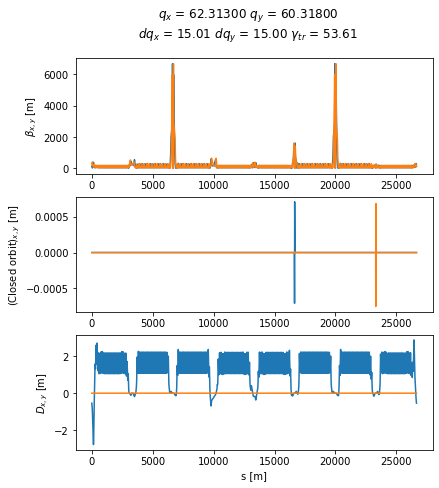

array([120.29057059, 120.29057059, 120.29057059, ..., 223.10537115,
       223.10537115, 120.29066114])

In [15]:
tw = tracker.twiss(particles_3)

fig1 = plt.figure(1, figsize=(6.4, 4.8*1.5))
spbet = plt.subplot(3,1,1)
spco = plt.subplot(3,1,2, sharex=spbet)
spdisp = plt.subplot(3,1,3, sharex=spbet)

spbet.plot(tw['s'], tw['betx'])
spbet.plot(tw['s'], tw['bety'])

spco.plot(tw['s'], tw['x'])
spco.plot(tw['s'], tw['y'])

spdisp.plot(tw['s'], tw['dx'])
spdisp.plot(tw['s'], tw['dy'])

spbet.set_ylabel(r'$\beta_{x,y}$ [m]')
spco.set_ylabel(r'(Closed orbit)$_{x,y}$ [m]')
spdisp.set_ylabel(r'$D_{x,y}$ [m]')
spdisp.set_xlabel('s [m]')

fig1.suptitle(
    r'$q_x$ = ' f'{tw["qx"]:.5f}' r' $q_y$ = ' f'{tw["qy"]:.5f}' '\n'
    r"$dq_x$ = " f'{tw["dqx"]:.2f}' r" $dq_y$ = " f'{tw["dqy"]:.2f}'
    r' $\gamma_{tr}$ = '  f'{1/np.sqrt(tw["momentum_compaction_factor"]):.2f}'
)



plt.show()
tw['betx']

Now for the tracking:
- n_turns is the step that we want to use to define when to sample our particles; for example if n_turns=10 then after 10 turns the variables will be saved;
- N_arr is the dimension of the arrays of the variables related to the beam and also tells us how many times we want the 10 turns to be repeated for sampling. So if N_arr = 100 and n_turns = 10 we will track the particles over 10 turns, register the final x,px...values and repeat again for 100 times.
For simplicity we will stick to n_turns=1 and N_arr=....

How can we use the results of the twiss to see the closed orbit and track it?
If we define (as before) `tw = tracker.twiss(particles_3)` then tw will have the particle on closed orbit saved as a particle object via `tw['particle_on_co']`-> we define a particle exactly on the closed orbit and a particle near it (i.e. with x a little bit further, let's say $10^{-5}$)

In [16]:
n_turns = 1
N_arr=1000
x_part0 = np.zeros(N_arr)
px_part0 = np.zeros(N_arr)
y_part0 = np.zeros(N_arr)
py_part0 = np.zeros(N_arr)
zeta_part0 = np.zeros(N_arr)
delta_part0 = np.zeros(N_arr)

x_part1 = np.zeros(N_arr)
px_part1 = np.zeros(N_arr)
y_part1 = np.zeros(N_arr)
py_part1 = np.zeros(N_arr)
zeta_part1 = np.zeros(N_arr)
delta_part1 = np.zeros(N_arr)

tw = tracker.twiss(particles_3)
co_part=tw['particle_on_co']
near_co_particle=tw['particle_on_co']


for ii in range(N_arr):
    tracker.track(co_part, num_turns=n_turns,turn_by_turn_monitor=False)
    #print(particles_3.x)
    x_part0[ii]=co_part.x
    px_part0[ii]=co_part.px
    y_part0[ii]=co_part.y
    py_part0[ii]=co_part.py
    zeta_part0[ii]=co_part.zeta
    delta_part0[ii]=co_part.delta
    #print(zeta_part0[ii],delta_part0[ii])
    
near_co_particle.x=near_co_particle.x+6*0.00021990181745701876

for ii in range(N_arr):
    tracker.track(near_co_particle, num_turns=n_turns,turn_by_turn_monitor=False)
    #print(particles_3.x)
    x_part1[ii]=near_co_particle.x
    px_part1[ii]=near_co_particle.px
    y_part1[ii]=near_co_particle.y
    py_part1[ii]=near_co_particle.py
    zeta_part1[ii]=near_co_particle.zeta
    delta_part1[ii]=near_co_particle.delta
    #print(zeta_part1[ii],delta_part1[ii])


In [17]:
if False:
    tw = tracker.twiss(particles_3)
    print(tw['particle_on_co'].x)
    a=tw['particle_on_co']
    #a.x=0
    ciao = tracker.track(a, num_turns=100)
    a.x
    near_particle = a 
    near_particle.x=near_particle.x+1e-5

We can now get a look at the variables!
We immediately see that the particle on the closed orbit, blue, is not oscillating, while the near particle is performing betatron motion (zoom over the first 50 turns).

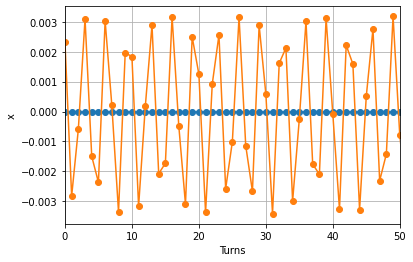

In [18]:
plt.plot(x_part0,'-o')
plt.plot(x_part1,'-o')


plt.grid()
plt.xlabel('Turns')
plt.ylabel('x');
plt.xlim(0,50);

By looking at the x,px plot we can see the oscillatory motion and the stable motion of the closed orbit particle.

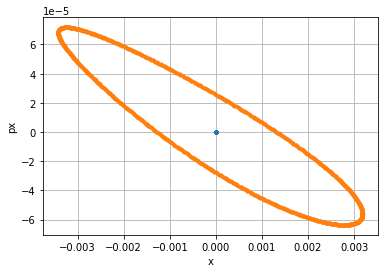

In [19]:
plt.plot(x_part0,px_part0,'.')
plt.plot(x_part1,px_part1,'.')
plt.grid()
plt.xlabel('x')
plt.ylabel('px');

By looking at the z,$\delta$ plot we discover something: the energy of the near particle is slightly oscillating! This means that the particle is giving out energy in the transverse direction periodically.
In this case, since the numbers are so small we can attribute it to numerical precision, but this behaviour is true in general.

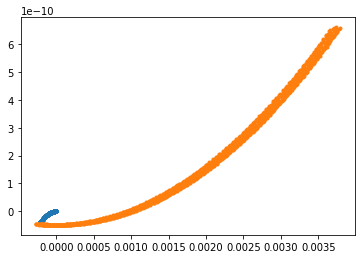

In [26]:
plt.plot(zeta_part0,delta_part0,'.');
plt.plot(zeta_part1,delta_part1,'.');
#plt.plot(delta_part,'o');

As a proof of this "leakage" of energy the y,py plot is the following: the transverse motion has been excited.

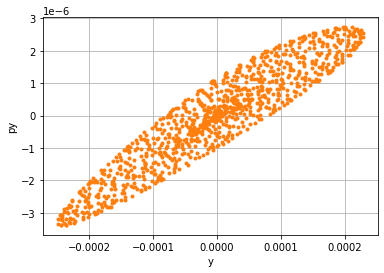

In [21]:
plt.plot(y_part0,py_part0,'.')
plt.plot(y_part1,py_part1,'.')
plt.grid()
plt.xlabel('y')
plt.ylabel('py');

## Tune reconstruction via FFT and Octupoles effect

Having tracked the particles inside the machine it is possible to analyze their x spectrum to calculate the tune. To do this we perform a Fast Fourier Transform. The tune at this point can be retrieved as a **FRACTIONAL** tune.
Looking at the plot you will see a flat line (blue), referring to the continuous spectrum of the closed orbit AND the continuous spectrum of the other particle. The particle on the closed orbit is not oscillating, thus the spectrum is continuous. The spike around 0.31 is the fractional tune of the oscillating particle.

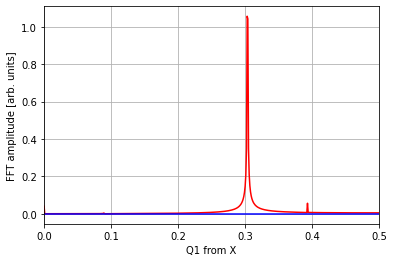

In [22]:
#Max_reco_freq= sampling frequency/2.
plt.figure()
plt.plot(np.linspace(0,1,len(x_part1)), np.abs(np.fft.fft(x_part1)), 'r')
plt.plot(np.linspace(0,1,len(x_part0)), np.abs(np.fft.fft(x_part0)), 'b')
plt.xlabel('Q1 from X')
plt.ylabel('FFT amplitude [arb. units]')
plt.xlim(0,0.5)
plt.grid()
#print(np.abs(np.fft.fft(x_part)))

We can now see the octupoles effect on the particles. We take as reference the Closed Orbit and some other particles, defined with a certain distance from the first one. We fix:
- The octupoles current to -350 Ampere.
- The measurement position at IP3 ($\beta_{x}$=120.29044352)
- $\sigma_{x}$=$\sqrt{\frac{\beta_{x}\epsilon}{\gamma}}$, with $\epsilon=3\times10^{-6}$

In [23]:
gamma=7000/.938
sigma_x=np.sqrt(120.29057045*3e-6/gamma)
sigma_x

0.00021990181745701876

We will now perform two different trackings: the first one will be with the Octupole current set to zero, the second one with the octupoles on.
Setting the current to zero:

In [24]:
line.vars['i_mo'] = 0

In [40]:
tracker2 = xt.Tracker(_context=ctx, line=line)
n_turns = 1
N_arr=1000
#x_part0 = np.zeros(N_arr)
#x_part1 = np.zeros(N_arr)
x_part2 = np.zeros(N_arr)
x_part3 = np.zeros(N_arr)
x_part4 = np.zeros(N_arr)
x_part5 = np.zeros(N_arr)

tw = tracker2.twiss(particles_3)
#co_part=tw['particle_on_co']
#near_co_particle1=tw['particle_on_co']
near_co_particle2=tw['particle_on_co']
near_co_particle3=tw['particle_on_co']
near_co_particle4=tw['particle_on_co']
near_co_particle5=tw['particle_on_co']


if False:
    for ii in range(N_arr):
        tracker2.track(co_part, num_turns=n_turns,turn_by_turn_monitor=False)
        #print(particles_3.x)
        x_part0[ii]=co_part.x
    
#near_co_particle1.x=near_co_particle1.x+0.2*sigma_x
near_co_particle2.x=near_co_particle2.x+2*sigma_x
near_co_particle3.x=near_co_particle3.x+3*sigma_x
near_co_particle4.x=near_co_particle4.x+4*sigma_x
near_co_particle5.x=near_co_particle5.x+5*sigma_x

if False:
    for ii in range(N_arr):
        tracker2.track(near_co_particle1, num_turns=n_turns,turn_by_turn_monitor=False)
        x_part1[ii]=near_co_particle1.x
        #print(x_part1[ii])
for ii in range(N_arr):
    tracker2.track(near_co_particle2, num_turns=n_turns,turn_by_turn_monitor=False)
    x_part2[ii]=near_co_particle2.x
    #print(x_part2[ii])
for ii in range(N_arr):
    tracker2.track(near_co_particle3, num_turns=n_turns,turn_by_turn_monitor=False)
    x_part3[ii]=near_co_particle3.x
    #print(x_part3[ii])
for ii in range(N_arr):
    tracker2.track(near_co_particle4, num_turns=n_turns,turn_by_turn_monitor=False)
    x_part4[ii]=near_co_particle4.x
for ii in range(N_arr):
    tracker2.track(near_co_particle5, num_turns=n_turns,turn_by_turn_monitor=False)
    x_part5[ii]=near_co_particle5.x
    
#print(x_part1[ii])

generating ./697c3518841c4d66afc4b1bc42eef139.c
the current directory is '/afs/cern.ch/user/a/afornara/simulations/2022_02_07/thick/postprocessing'
running build_ext
building '697c3518841c4d66afc4b1bc42eef139' extension
gcc -pthread -B /home/afornara/py/2022_03_02/miniconda/compiler_compat -Wno-unused-result -Wsign-compare -DNDEBUG -O2 -Wall -fPIC -O2 -isystem /home/afornara/py/2022_03_02/miniconda/include -I/home/afornara/py/2022_03_02/miniconda/include -fPIC -O2 -isystem /home/afornara/py/2022_03_02/miniconda/include -fPIC -I/home/afornara/py/2022_03_02/miniconda/include/python3.9 -c 697c3518841c4d66afc4b1bc42eef139.c -o ./697c3518841c4d66afc4b1bc42eef139.o -std=c99 -O3 -Wno-unused-function
gcc -pthread -B /home/afornara/py/2022_03_02/miniconda/compiler_compat -shared -Wl,-rpath,/home/afornara/py/2022_03_02/miniconda/lib -Wl,-rpath-link,/home/afornara/py/2022_03_02/miniconda/lib -L/home/afornara/py/2022_03_02/miniconda/lib -L/home/afornara/py/2022_03_02/miniconda/lib -Wl,-rpath,/home

In [23]:
#Max_reco_freq= sampling frequency/2.
plt.figure()
#plt.plot(np.linspace(0,1,len(x_part0)), np.abs(np.fft.fft(x_part0)), 'b')
#plt.plot(np.linspace(0,1,len(x_part1)), np.abs(np.fft.fft(x_part1)), 'c')
plt.plot(np.linspace(0,1,len(x_part2)), np.abs(np.fft.fft(x_part2)), 'm')
plt.plot(np.linspace(0,1,len(x_part3)), np.abs(np.fft.fft(x_part3)), 'y')
plt.plot(np.linspace(0,1,len(x_part4)), np.abs(np.fft.fft(x_part4)), 'g')
plt.plot(np.linspace(0,1,len(x_part5)), np.abs(np.fft.fft(x_part5)), 'r')
plt.xlabel('Q1 from X')
plt.ylabel('FFT amplitude [arb. units]')
plt.xlim(0.31,0.32)
plt.grid()
#print(np.abs(np.fft.fft(x_part)))

NameError: name 'x_part2' is not defined

<Figure size 432x288 with 0 Axes>

Big problem: maybe there's an effect, maybe not, the precision of the Numpy fft is too low for this problem.
We need to use a better Fast Fourier Transform, and it is provided by the NAFFlib package.

In [42]:
#q0 = NAFFlib.get_tune(x_part0)
#q1 = NAFFlib.get_tune(x_part1)
q2 = NAFFlib.get_tune(x_part2)
q3 = NAFFlib.get_tune(x_part3)
q4 = NAFFlib.get_tune(x_part4)
q5 = NAFFlib.get_tune(x_part5)
print('q2 =', q2, ', q3 =', q3, ', q4 =', q4,', q5 =', q5)
tunes = np.zeros(4)
positions = np.zeros(4)
#tunes[0]=q0
#tunes[0]=q1
tunes[0]=q2
tunes[1]=q3
tunes[2]=q4
tunes[3]=q5
#positions[0]=x_part0[0] 
#positions[0]=near_co_particle1.x+0.2*sigma_x
positions[0]=near_co_particle2.x+2*sigma_x
positions[1]=near_co_particle3.x+3*sigma_x
positions[2]=near_co_particle4.x+4*sigma_x
positions[3]=near_co_particle5.x+5*sigma_x
#print(positions[1],tunes[1])

q2 = 0.24999342196841076 , q3 = 0.2489405515015057 , q4 = 0.2499981022714928 , q5 = 0.24999669947021194


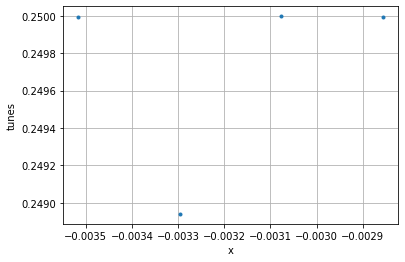

In [43]:
plt.plot(positions,tunes,'.')
plt.grid()
plt.xlabel('x')
plt.ylabel('tunes');
#plt.ylim(0.312,0.315)

We now perform the same thing but with the Octupoles on.

In [44]:
line.vars['i_mo'] = -350

Now we track a number of particles with some sigmas of distance between each other

In [45]:
tracker3 = xt.Tracker(_context=ctx, line=line)
n_turns = 1
N_arr=1000
#x_part0 = np.zeros(N_arr)
#x_part1 = np.zeros(N_arr)
x_part2 = np.zeros(N_arr)
x_part3 = np.zeros(N_arr)
x_part4 = np.zeros(N_arr)
x_part5 = np.zeros(N_arr)

tw = tracker3.twiss(particles_3)
#co_part=tw['particle_on_co']
#near_co_particle1=tw['particle_on_co']
near_co_particle2=tw['particle_on_co']
near_co_particle3=tw['particle_on_co']
near_co_particle4=tw['particle_on_co']
near_co_particle5=tw['particle_on_co']


if False:
    for ii in range(N_arr):
        tracker3.track(co_part, num_turns=n_turns,turn_by_turn_monitor=False)
        #print(particles_3.x)
        x_part0[ii]=co_part.x
    
#near_co_particle1.x=near_co_particle1.x+0.2*sigma_x
near_co_particle2.x=near_co_particle2.x+2*sigma_x
near_co_particle3.x=near_co_particle3.x+3*sigma_x
near_co_particle4.x=near_co_particle4.x+4*sigma_x
near_co_particle5.x=near_co_particle5.x+5*sigma_x

if False:
    for ii in range(N_arr):
        tracker3.track(near_co_particle1, num_turns=n_turns,turn_by_turn_monitor=False)
        x_part1[ii]=near_co_particle1.x
        #print(x_part1[ii])
for ii in range(N_arr):
    tracker3.track(near_co_particle2, num_turns=n_turns,turn_by_turn_monitor=False)
    x_part2[ii]=near_co_particle2.x
    #print(x_part2[ii])
for ii in range(N_arr):
    tracker3.track(near_co_particle3, num_turns=n_turns,turn_by_turn_monitor=False)
    x_part3[ii]=near_co_particle3.x
    #print(x_part3[ii])
for ii in range(N_arr):
    tracker3.track(near_co_particle4, num_turns=n_turns,turn_by_turn_monitor=False)
    x_part4[ii]=near_co_particle4.x
for ii in range(N_arr):
    tracker3.track(near_co_particle5, num_turns=n_turns,turn_by_turn_monitor=False)
    x_part5[ii]=near_co_particle5.x
    
#print(x_part1[ii])

generating ./ed955a80aa2349b1bd2676b4e5180c5d.c
the current directory is '/afs/cern.ch/user/a/afornara/simulations/2022_02_07/thick/postprocessing'
running build_ext
building 'ed955a80aa2349b1bd2676b4e5180c5d' extension
gcc -pthread -B /home/afornara/py/2022_03_02/miniconda/compiler_compat -Wno-unused-result -Wsign-compare -DNDEBUG -O2 -Wall -fPIC -O2 -isystem /home/afornara/py/2022_03_02/miniconda/include -I/home/afornara/py/2022_03_02/miniconda/include -fPIC -O2 -isystem /home/afornara/py/2022_03_02/miniconda/include -fPIC -I/home/afornara/py/2022_03_02/miniconda/include/python3.9 -c ed955a80aa2349b1bd2676b4e5180c5d.c -o ./ed955a80aa2349b1bd2676b4e5180c5d.o -std=c99 -O3 -Wno-unused-function
gcc -pthread -B /home/afornara/py/2022_03_02/miniconda/compiler_compat -shared -Wl,-rpath,/home/afornara/py/2022_03_02/miniconda/lib -Wl,-rpath-link,/home/afornara/py/2022_03_02/miniconda/lib -L/home/afornara/py/2022_03_02/miniconda/lib -L/home/afornara/py/2022_03_02/miniconda/lib -Wl,-rpath,/home

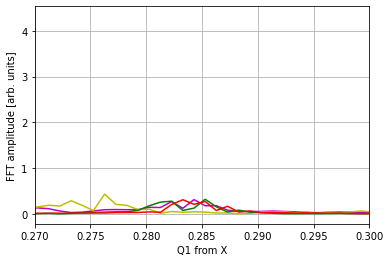

In [46]:
#Max_reco_freq= sampling frequency/2.
plt.figure()
#plt.plot(np.linspace(0,1,len(x_part0)), np.abs(np.fft.fft(x_part0)), 'b')
#plt.plot(np.linspace(0,1,len(x_part1)), np.abs(np.fft.fft(x_part1)), 'c')
plt.plot(np.linspace(0,1,len(x_part2)), np.abs(np.fft.fft(x_part2)), 'm')
plt.plot(np.linspace(0,1,len(x_part3)), np.abs(np.fft.fft(x_part3)), 'y')
plt.plot(np.linspace(0,1,len(x_part4)), np.abs(np.fft.fft(x_part4)), 'g')
plt.plot(np.linspace(0,1,len(x_part5)), np.abs(np.fft.fft(x_part5)), 'r')
plt.xlabel('Q1 from X')
plt.ylabel('FFT amplitude [arb. units]')
plt.xlim(0.27,0.30)
plt.grid()
#print(np.abs(np.fft.fft(x_part)))

In [47]:
#q0 = NAFFlib.get_tune(x_part0)
#q1 = NAFFlib.get_tune(x_part1)
q2 = NAFFlib.get_tune(x_part2)
q3 = NAFFlib.get_tune(x_part3)
q4 = NAFFlib.get_tune(x_part4)
q5 = NAFFlib.get_tune(x_part5)
print('q2 =', q2, ', q3 =', q3, ', q4 =', q4,', q5 =', q5)
tunes = np.zeros(4)
positions = np.zeros(4)
#tunes[0]=q0
#tunes[0]=q1
tunes[0]=q2
tunes[1]=q3
tunes[2]=q4
tunes[3]=q5
#positions[0]=x_part0[0] 
#positions[0]=near_co_particle1.x+0.2*sigma_x
positions[0]=near_co_particle2.x+2*sigma_x
positions[1]=near_co_particle3.x+2.5*sigma_x
positions[2]=near_co_particle4.x+4*sigma_x
positions[3]=near_co_particle5.x+5*sigma_x
print(positions[1],tunes[1])

q2 = 0.24999342196841076 , q3 = 0.2489405515015057 , q4 = 0.2499981022714928 , q5 = 0.24999669947021194
-0.003406431762772247 0.2489405515015057


-99.23454504473932

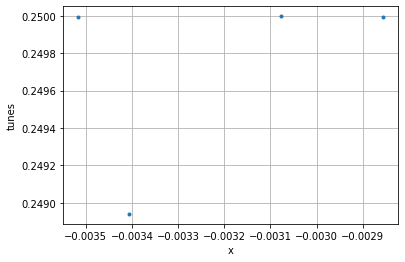

In [48]:
plt.plot(positions,tunes,'.')
m = (K_OCT*120.29057045*120.29057045)/(32*np.pi)
plt.grid()
plt.xlabel('x')
plt.ylabel('tunes');
#plt.ylim(0.312,0.315)
m

In [34]:
q2_1 = 0.3153000634927122
q3_1 = 0.3153163387772643
q4_1 = 0.3153041836968696
q5_1 = 0.31531386138726886
#q2 = 0.24999342196841076 , q3 = 0.2489405515015057 , q4 = 0.2499981022714928 , q5 = 0.24999669947021194


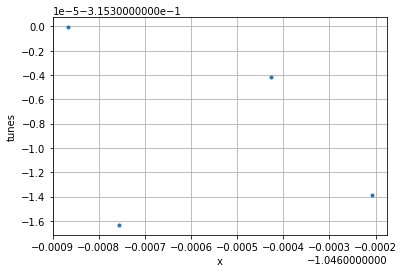

In [35]:
detunes = np.zeros(4)
detunes[0]=q2-q2_1
detunes[1]=q3-q3_1
detunes[2]=q4-q4_1
detunes[3]=q5-q5_1
plt.plot(positions,detunes,'.')
m = (K_OCT*120.29057045*120.29057045)/(32*np.pi)
plt.grid()
plt.xlabel('x')
plt.ylabel('tunes');
#plt.ylim(0.312,0.315)

In [36]:
tw.keys()
a = tw['particle_on_co']
tw['particle_on_co'].zeta
a?

Type:        Particles
String form: <xpart.particles.particles.Particles object at 0x7f0ae1562730>
File:        ~/py/2022_03_02/miniconda/lib/python3.9/site-packages/xpart/particles/particles.py
Docstring:  
Particle objects have the following fields:

     - s [m]:  Reference accumulated pathlength
     - x [m]:  Horizontal position
     - px[1]:  Px / (m/m0 * p0c) = beta_x gamma /(beta0 gamma0)
     - y [m]:  Vertical position
     - py [1]:  Py / (m/m0 * p0c)
     - delta[1]:  Pc / (m/m0 * p0c) - 1
     - ptau [1]:  Energy / (m/m0 * p0c) - 1
     - psigma [1]:  ptau/beta0
     - rvv [1]:  beta/beta0
     - rpp [1]:  1/(1+delta) = (m/m0 * p0c) / Pc
     - zeta [m]:  beta (s/beta0 - ct )
     - tau [m]:
     - sigma [m]:  s - beta0 ct = rvv * zeta
     - mass0 [eV]:
     - q0 [e]:  Reference charge
     - p0c [eV]: Reference momentum
     - energy0 [eV]: Reference energy
     - gamma0 [1]:  Reference relativistic gamma
     - beta0 [1]:  Reference relativistix beta
     - chi [1]:  q/

Altro studio interessante: queste linee stanno in config.yaml, i dQx...ci dicono quanto siamo vicini in tune, posso variarli per capire, ad esempio, come i tune si avvicinano l'uno all'altro a croce.
A quel punto mi accorgo che i due tune si accoppiano e non riescono a toccarsi->uso i CMRS e CMIS per disaccoppiarli.

 Knobs associated to sequences                                               
121   qknob_1:                                                                      
122     lhcb1: dQx.b1_sq                                                            
123     lhcb2: dQx.b2_sq                                                            
124   qknob_2:                                                                      
125     lhcb1: dQy.b1_sq                                                            
126     lhcb2: dQy.b2_sq                                                            
127   chromknob_1:                                                                  
128     lhcb1: dQpx.b1_sq                                                           
129     lhcb2: dQpx.b2_sq                                                           
130   chromknob_2:                                                                  
131     lhcb1: dQpy.b1_sq                                                           
132     lhcb2: dQpy.b2_sq                                                           
133   cmrknob:                                                                      
134     lhcb1: CMRS.b1_sq                                                           
135     lhcb2: CMRS.b2_sq                                                           
136   cmiknob:                                                                      
137     lhcb1: CMIS.b1_sq                                                           
138     lhcb2: CMIS.b2_sq               